In [111]:
from io import BytesIO

import cv2
import numpy as np
import matplotlib.pyplot as plt

import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000


def are_images_similar(img1, img2, threshold=0.70):
    # Standardize sizes
    img1 = cv2.resize(img1, (1024, 1024))
    img2 = cv2.resize(img2, (1024, 1024))

    # Convert to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # show images
    # plt.subplot(1, 2, 1)
    # plt.imshow(img1)
    # plt.subplot(1, 2, 2)
    # plt.imshow(img2)
    # plt.show()

    # Compute similarity
    similarity = cv2.matchTemplate(img1, img2, cv2.TM_CCOEFF_NORMED)
    max_similarity = np.max(similarity)
    print("Max similarity: {}".format(max_similarity))

    return max_similarity > threshold

def findOmeroImageFromSirenLR(conn, lr_filepath, threshold=0.70, parse_filepath = True):
    # Get all images
    images = conn.getObjects("Image")
    # Try to narrow it down if requested
    if parse_filepath:
        if lr_filepath.startswith("/Volumes/Siren/Prostate"):
            # set to prostate group
            conn.SERVICE_OPTS.setOmeroGroup(3)
            splitted = lr_filepath.split("/")
            # patient id is after the 5th slash, add prostate indicator
            dataset = f"{splitted[4][1:]}_p"
            # slide number is the 3rd last element, format as a 2 digit int with an S in front
            slide = splitted[-3]
            if '_'  in slide:
                slide = slide.split('_')[0]
            slide = f"S{int(slide):02d}"
            for dataset in conn.getObjects("Dataset", attributes={'name': dataset}):
                close_match, patient_images = [], []
                for img in conn.getObjects("Image", opts={'dataset': dataset.getId()}):
                    if slide in img.getName():
                        close_match.append(img)
                    else:
                        patient_images.append(img)

                close_match.extend(patient_images)
                images = close_match

    # Load the image
    lr_img = np.array(Image.open(lr_filepath))

    # Loop through images
    for image in images:
        # Get the image data
        img_data = image.getThumbnail(1024)
        thumbnail = Image.open(BytesIO(img_data))
        thumbnail = np.array(thumbnail, dtype=np.uint8)

        # Check if images are similar
        if are_images_similar(lr_img, thumbnail, threshold):
            return image

    return None

from omero.gateway import BlitzGateway

conn = BlitzGateway('', '', host='wsi.lavlab.mcw.edu', port=4064, secure=True)
conn.connect()

print(findOmeroImageFromSirenLR(conn, '/Volumes/Siren/Prostate_data/1101/Hist/8_incl/Huron/large_recon_10_nowhite.tiff'))



101_p
101_p
N101_S08_HE.ome.tiff
N101_S10_HE.ome.tiff
N101_S12_HE.ome.tiff
N101_S09_HE.ome.tiff
N101_S06_HE.ome.tiff
N101_S05_HE.ome.tiff
N101_S11_HE.ome.tiff


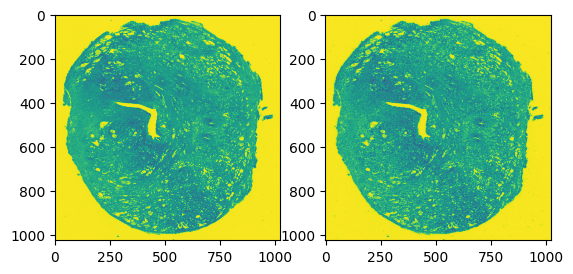

Max similarity: 0.7521485090255737
<_ImageWrapper id=358>


In [75]:
from PIL import Image
from io import BytesIO
test_id = ''
img = conn.getObject('Image', test_id)
img_data = img.getThumbnail(1024)
thumbnail = Image.open(BytesIO(img_data))
thumbnail = np.array(thumbnail, dtype=np.uint8)


(24250, 16914, 3)
(1024, 617, 3)


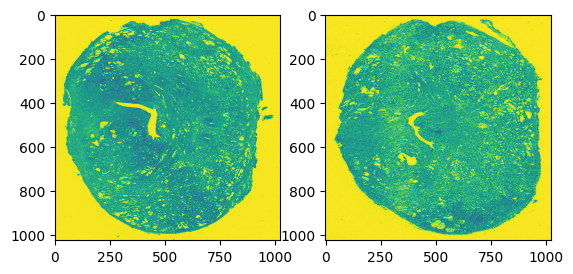

Max similarity: 0.4241722822189331
The images are not similar


In [76]:

print(control.shape)
print(thumbnail.shape)
similar = are_images_similar(control, thumbnail)
print("The images are similar" if similar else "The images are not similar")
